In [22]:
import numpy as np
import json
import subprocess
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import re

In [23]:

sns.set_style('whitegrid')

ANNOTATIONS_FILE = 'ground_truth_annotations.json'
BINARY = '../bin/slice_localize'
IMGS_DIR = '../data'
#ITER_VALUES = list(range(0, 1001, 10)); ITER_VALUES[0] = 1
ITER_VALUES = sorted(set(
    np.logspace(np.log10(1), np.log10(1000), num=100, dtype=int)
))

 ## Ground-truth anotace

In [24]:
with open(ANNOTATIONS_FILE, 'r', encoding='utf-8') as f:
    annotations = json.load(f)

 ## Výpočet IoU

In [25]:
def compute_iou(poly1, poly2):
    p1 = Polygon(poly1)
    p2 = Polygon(poly2)
    if not p1.is_valid or not p2.is_valid:
        return 0.0
    inter = p1.intersection(p2).area
    union = p1.union(p2).area
    return inter / union if union > 0 else 0.0

 ## Vyhodnocení

In [26]:
results = {}

for img_name, gt_data in annotations.items():
    # ground-truth polygon
    region = next(iter(gt_data['regions'].values()))['shape_attributes']
    xs = region['all_points_x'][:4]
    ys = region['all_points_y'][:4]
    gt_pts = list(zip(xs, ys))

    ious = []
    img_path = os.path.join(IMGS_DIR, img_name)
    for it in ITER_VALUES:
        cmd = [BINARY, '--iterations', str(it), img_path]
        proc = subprocess.run(cmd, capture_output=True, text=True)
        if proc.returncode != 0:
            print(f"Chyba: {img_name} it={it} → {proc.stderr.strip()}")
            ious.append(0.0)
            continue

        # parsování řádků se souřadnicemi "x y"
        pred_pts = [tuple(map(int, line.split()))
                    for line in proc.stdout.strip().splitlines()][:4]

        # IoU
        ious.append(compute_iou(pred_pts, gt_pts))

    results[img_name] = {'iters': ITER_VALUES, 'ious': ious}

 ## Grafy

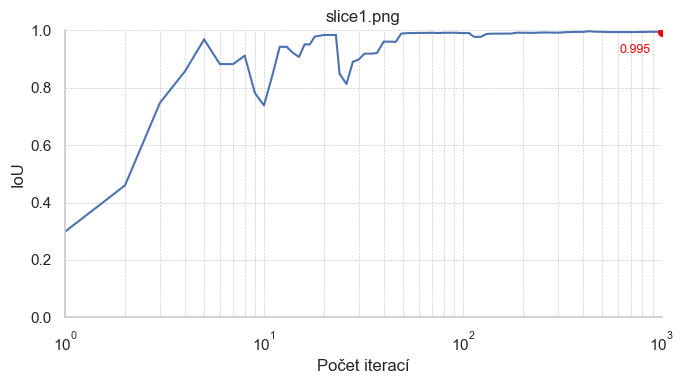

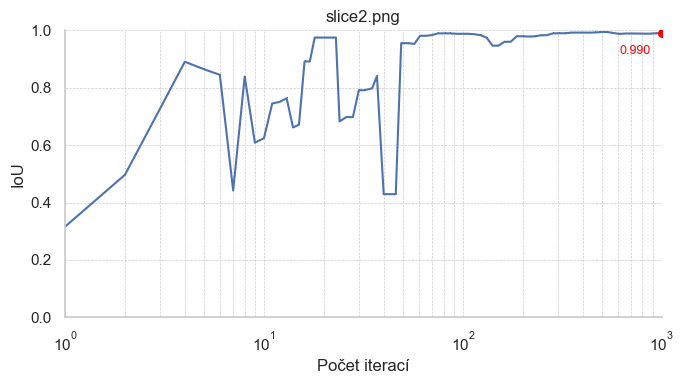

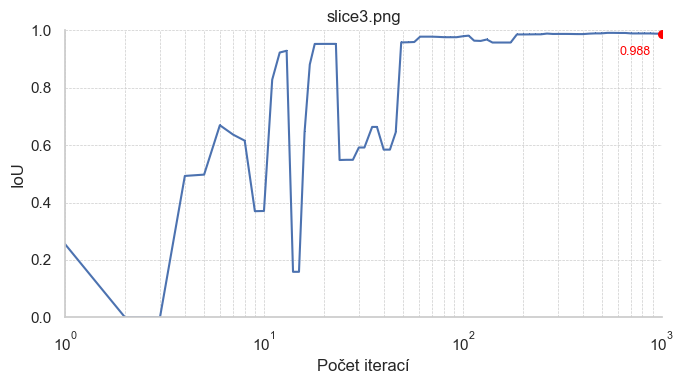

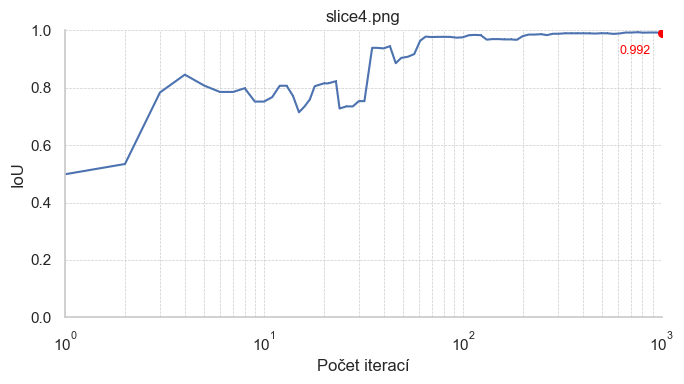

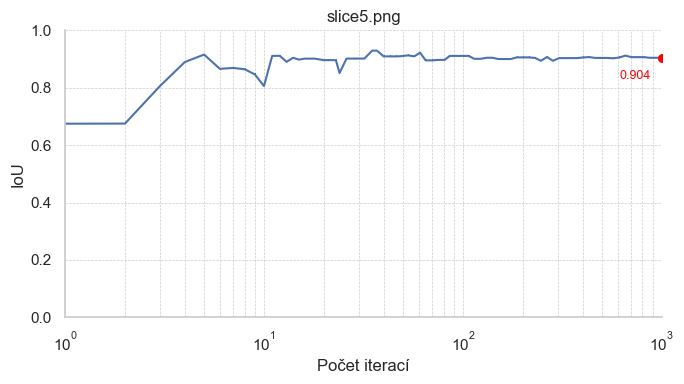

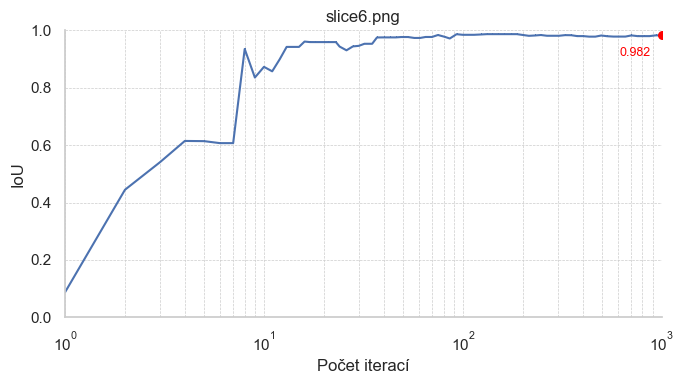

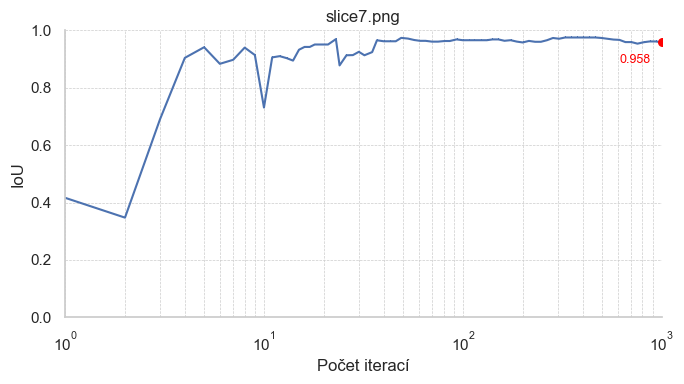

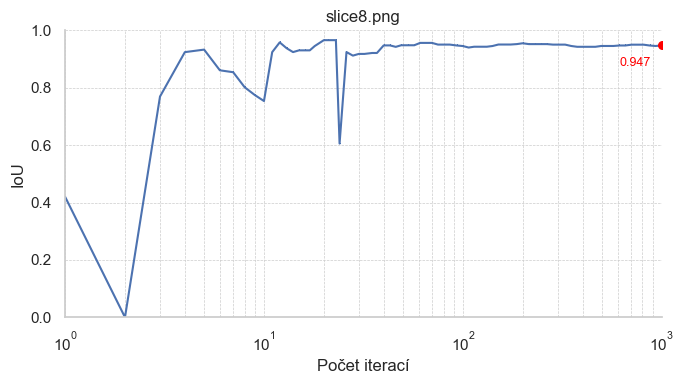

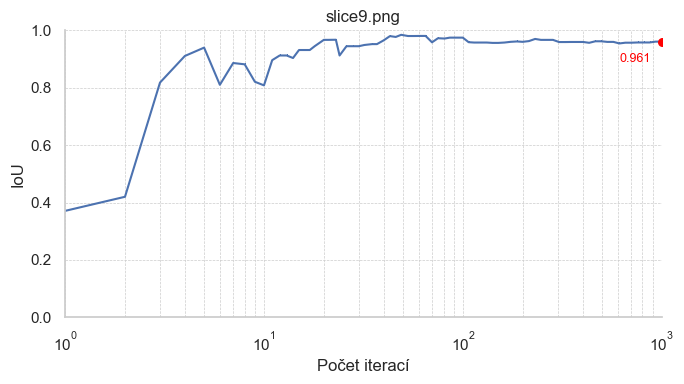

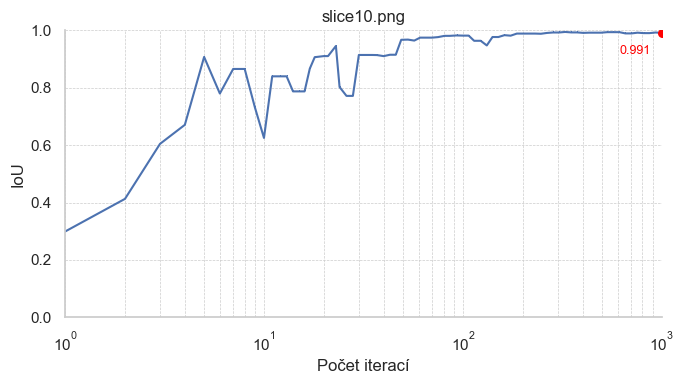

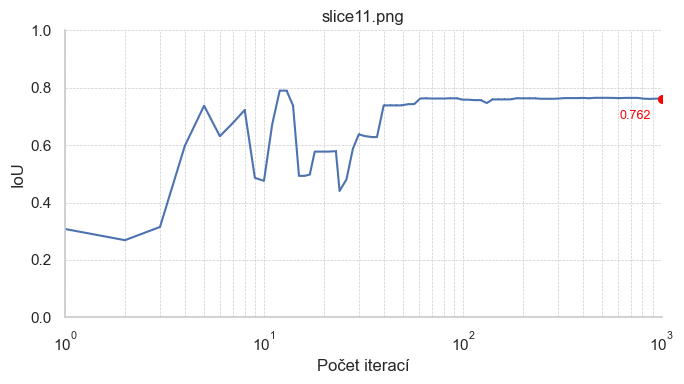

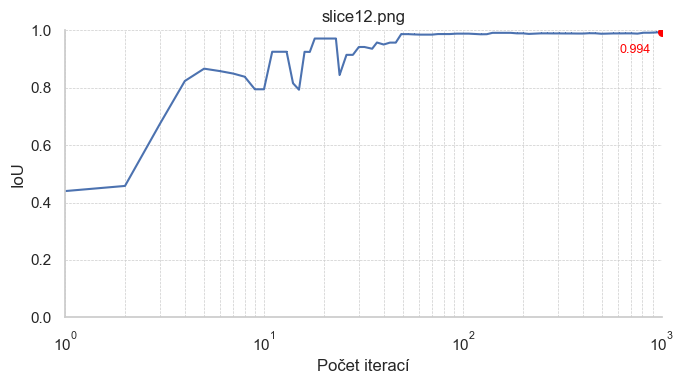

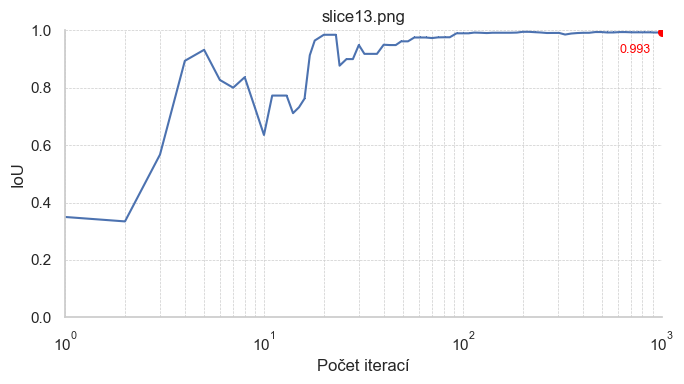

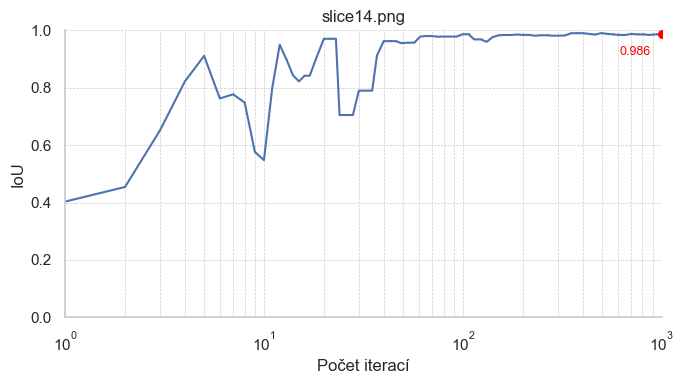

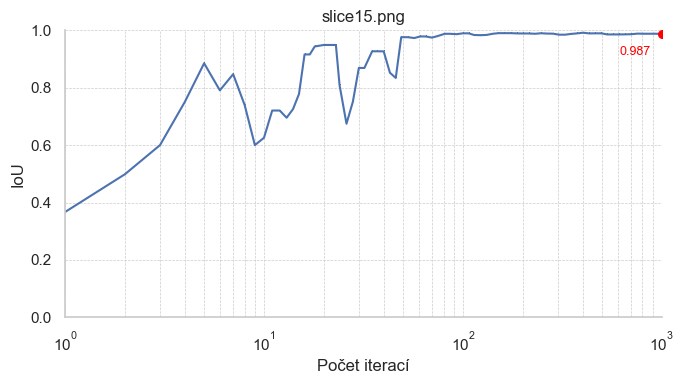

In [43]:
def slice_key(fn):
    return int(re.search(r'(\d+)', fn).group(1))

for img_name, data in sorted(results.items(), key=lambda kv: slice_key(kv[0])):
    # DF pro seaborn
    df = pd.DataFrame({
        'iterations': data['iters'],
        'iou': data['ious']
    })

    fig, ax = plt.subplots(figsize=(7, 4))
    sns.lineplot(
        data=df,
        x='iterations',
        y='iou',
        marker=',',
        ax=ax
    )

    ax.set_xscale('log')

    ax.set_title(img_name)
    ax.set_xlabel("Počet iterací")
    ax.set_ylabel("IoU")

    ax.set_xlim(1, 1000)
    ax.set_ylim(0, 1)

    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    sns.despine(ax=ax, top=True, right=True)

    # anotace posledního iterace
    last_it  = df['iterations'].iloc[-1]
    last_val = df['iou'].iloc[-1]
    ax.scatter([last_it], [last_val], color='red', s=30, zorder=10)
    ax.annotate(f"{last_val:.3f}",
                xy=(last_it, last_val),
                xytext=(-30, -15),
                textcoords='offset points',
                color='red',
                fontsize=9)

    plt.tight_layout()
    plt.show()

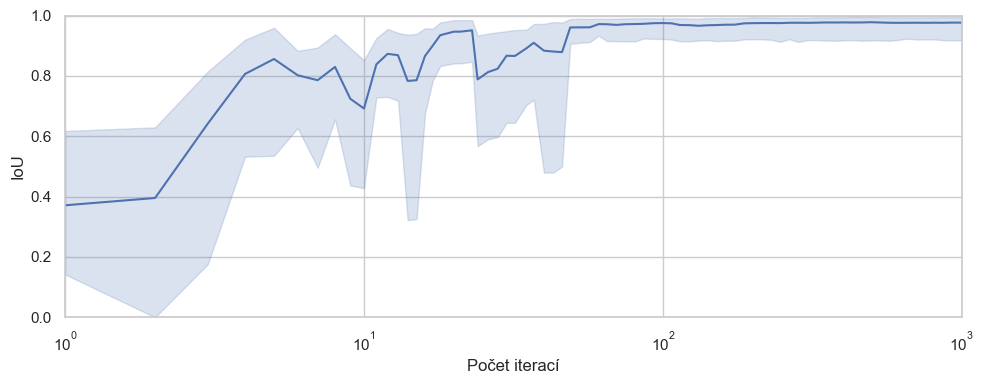

In [39]:
# DF se všemi iteracemi a IoU (bez slice11.png)
records = []
for img_name, data in results.items():
    if img_name == 'slice11.png':
        continue
    for it, iou in zip(data['iters'], data['ious']):
        records.append({'iterations': it, 'iou': iou})
df = pd.DataFrame(records)

plt.figure(figsize=(10, 4))
ax = sns.lineplot(
    data      = df,
    x         = 'iterations',
    y         = 'iou',
    estimator = 'mean',
    errorbar  = 'pi',   # 95% interval spolehlivosti
)
ax.set_xlim(1, 1000)
ax.set_ylim(0, 1)
ax.set_xscale('log')
ax.set_xlabel('Počet iterací')
ax.set_ylabel('IoU')
plt.tight_layout()
plt.show()

In [40]:
df = df[df['iterations'] == 1000]
mean_iou = df['iou'].mean()
var_iou = df['iou'].var()
print("Mean:\n", f"{mean_iou:.4f}")
print("Variance:\n", f"{var_iou:.4f}")

Mean:
 0.9764
Variance:
 0.0007
